<a href="https://colab.research.google.com/github/srhill12/waco-prophet-rnn-predictions/blob/main/Waco_Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeooi96z6/9joka_kv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpeooi96z6/2e575is0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26002', 'data', 'file=/tmp/tmpeooi96z6/9joka_kv.json', 'init=/tmp/tmpeooi96z6/2e575is0.json', 'output', 'file=/tmp/tmpeooi96z6/prophet_model22z2agy4/prophet_model-20240703234322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:43:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:43:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/20
25/25 [==============================] - 7s 55ms/step - loss: nan - val_loss: nan
Epoch 2/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 3/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 4/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 5/20
25/25 [==============================] - 0s 17ms/step - loss: nan - val_loss: nan
Epoch 6/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 7/20
25/25 [==============================] - 0s 17ms/step - loss: nan - val_loss: nan
Epoch 8/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 9/20
25/25 [==============================] - 0s 15ms/step - loss: nan - val_loss: nan
Epoch 10/20
25/25 [==============================] - 0s 16ms/step - loss: nan - val_loss: nan
Epoch 11/20
25/25 [==============================] - 0s 14ms/step - l

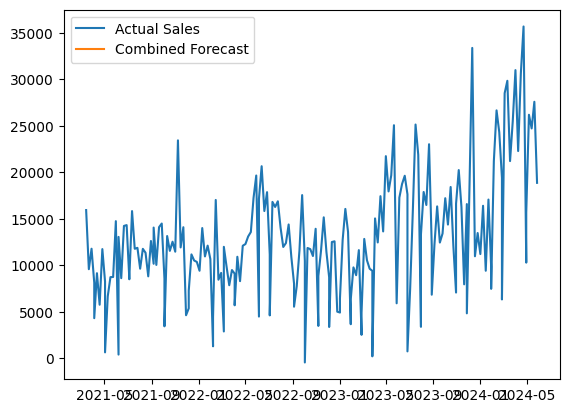

In [4]:
import pandas as pd
from prophet import Prophet
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load and preprocess the data
data = pd.read_csv('/new_renamed_store3_data.csv')
data['ds'] = pd.to_datetime(data['date'])
data['y'] = data['Sales']

# Train the Prophet model
prophet_model = Prophet()
prophet_model.fit(data)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=365)
forecast = prophet_model.predict(future)

# Calculate residuals
data['residual'] = data['y'] - forecast['yhat']

# Prepare residuals for RNN
residuals = data['residual'].values
residuals = residuals.reshape(-1, 1)

# Normalize the residuals
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
residuals = scaler.fit_transform(residuals)

# Create sequences for RNN
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X, y = create_sequences(residuals, seq_length)

# Split into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the RNN model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the RNN
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict residuals with RNN
rnn_predictions = model.predict(X_test)
rnn_predictions = scaler.inverse_transform(rnn_predictions)

# Combine Prophet and RNN predictions
combined_forecast = forecast['yhat'][-len(rnn_predictions):].values + rnn_predictions.flatten()

# Evaluate the combined forecast
import matplotlib.pyplot as plt
plt.plot(data['ds'][-len(rnn_predictions):], data['y'][-len(rnn_predictions):], label='Actual Sales')
plt.plot(data['ds'][-len(rnn_predictions):], combined_forecast, label='Combined Forecast')
plt.legend()
plt.show()
